In [ ]:
!pip install polars pyarrow fastparquet matplotlib geopy

In [36]:
import polars as pl
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df = pl.read_parquet('../data/logs.parquet')

#### **1. Introduction**
First, I focused on **requests** as I have some prior experience in REST API. There, I noticed that one IP address was requesting somewhat differently from other requests.

The IP address `52.169.249.118` has been making repeated requests to access other WordPress-related PHP files.
  - Here, I had to do my own research because I'm not familiar with WordPress and PHP. 
  - According to the official document, WordPress is an open-source content management system commonly used for building websites. 

Why is this unusual?
  - According to [_isitwp.com_](https://isitwp.com/), BoilerExam does **not** use WordPress. 
  
      = requests may be part of an automated scan or a targeted attempt to exploit potential vulnerabilities.

The IP address `52.169.249.118` has been making repeated requests to access other WordPress-related PHP files.
  - Here, I had to do my own research because I'm not familiar with WordPress and PHP. 
  - According to the official document, WordPress is an open-source content management system commonly used for building websites. 

Why is this unusual?
  - According to [_isitwp.com_](https://isitwp.com/), BoilerExam does **not** use WordPress. 
  
      = requests may be part of an automated scan or a targeted attempt to exploit potential vulnerabilities.

In [32]:
# Run the SQL query
query = "SELECT * FROM data WHERE client_ip = '52.169.249.118';"
malicious_data = df.filter(pl.col('client_ip') == '52.169.249.118')

# Display the result
print(malicious_data)
malicious_data.write_csv('results/malcious_ip.csv')

shape: (458, 8)
┌─────────────┬──────┬─────────────┬─────────────┬─────────────┬────────────┬─────────┬────────────┐
│ client_ip   ┆ user ┆ time        ┆ request     ┆ http_status ┆ request_bo ┆ referer ┆ user_agent │
│ ---         ┆ ---  ┆ ---         ┆ ---         ┆ ---         ┆ dy_bytes   ┆ ---     ┆ ---        │
│ str         ┆ str  ┆ datetime[μs ┆ str         ┆ u16         ┆ ---        ┆ str     ┆ str        │
│             ┆      ┆ ]           ┆             ┆             ┆ u64        ┆         ┆            │
╞═════════════╪══════╪═════════════╪═════════════╪═════════════╪════════════╪═════════╪════════════╡
│ 52.169.249. ┆ null ┆ 2024-11-08  ┆ GET         ┆ 301         ┆ 178        ┆ null    ┆ null       │
│ 118         ┆      ┆ 00:20:17    ┆ /403.php    ┆             ┆            ┆         ┆            │
│             ┆      ┆             ┆ HTTP/1.1    ┆             ┆            ┆         ┆            │
│ 52.169.249. ┆ null ┆ 2024-11-08  ┆ GET         ┆ 200         ┆ 2580      

#### 2. **Request Analysis**
All high-frequency requests target files like `/wp-includes/`, `/wp-admin/`, and `/wp-content/`.

  - Each file was requested multiple times, indicating systematic probing, likely from an automated bot or script.

In [33]:
# Get the top 10 requested paths
request_counts = malicious_data['request'].value_counts().head(10)

# Display the counts of the top requests
request_counts

request,count
str,u32
"""GET /wp-includes/function.php …",2
"""GET /avaa.php HTTP/1.1""",2
"""GET /css/index.php HTTP/1.1""",2
"""GET /cgi-bin/radio.php HTTP/1.…",2
"""GET /.well-known/cloud.php HTT…",2
"""GET /chosen.php HTTP/1.1""",2
"""GET /wp-content/autoload_class…",2
"""GET /wp-content/plugins/dropdo…",2
"""GET /text.php HTTP/1.1""",2


#### 3. **Time-Based Observations**
A closer look at the timestamps of the requests reveals suspicious patterns:

- **High-Volume Burst**:
  - An overwhelming **438 requests** occurred in a single minute (20th minute of the hour).
  - This is a strong indicator of automated activity, such as a bot or a script rapidly probing for vulnerabilities.

- **Drop-Off**:
  - After the burst of activity, only 20 requests were observed in the next minute, suggesting:
    - The server may have implemented rate-limiting or defenses.
    - The bot/script may have stopped or switched its focus.


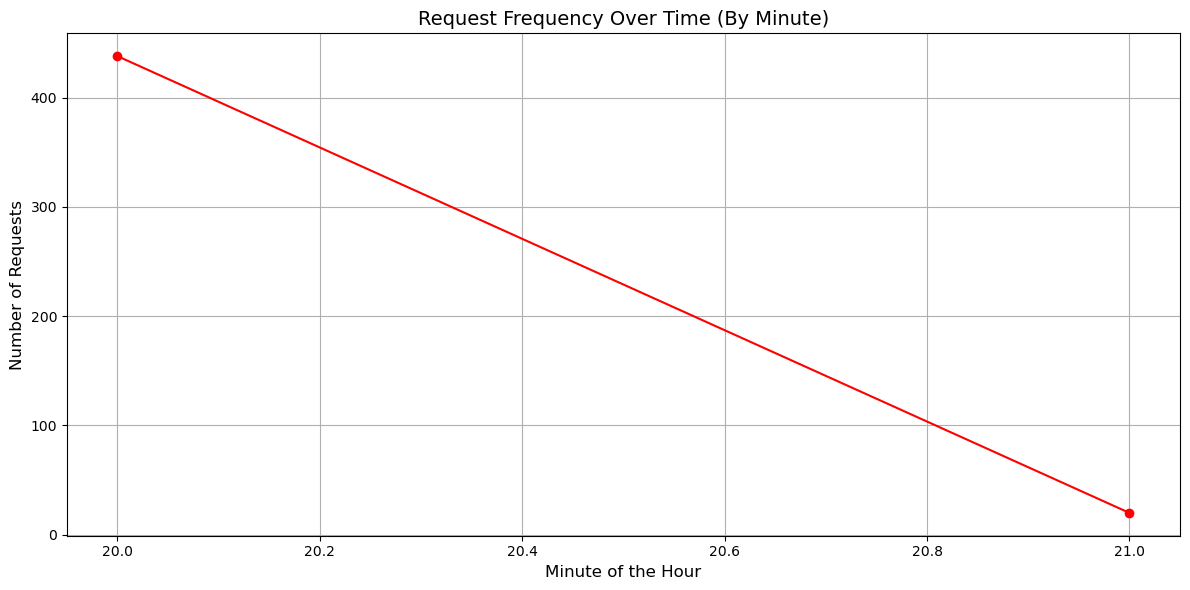

In [64]:
import polars as pl
import matplotlib.pyplot as plt

# Ensure 'time' is in datetime format
if malicious_data.schema["time"] != pl.Datetime:
    malicious_data = malicious_data.with_columns(
        pl.col("time").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%.f")
    )

# Extract the minute part from the datetime column
malicious_data = malicious_data.with_columns(
    pl.col("time").dt.minute().alias("minute")  # Extract the minute
)

# Count the occurrences per minute using Polars' grouping and aggregation
minute_counts = malicious_data.group_by("minute").agg([
    pl.col("time").count().alias("request_count")
])

# Convert to Pandas for plotting
minute_counts_df = minute_counts.to_pandas()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(minute_counts_df["minute"], minute_counts_df["request_count"], marker='o', color='red')
plt.title('Request Frequency Over Time (By Minute)', fontsize=14)
plt.xlabel('Minute of the Hour', fontsize=12)
plt.ylabel('Number of Requests', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Key Takeaways:
1. **Exploitation Suspected**:
   - The targeted paths and the volume of requests indicate exploitation attempts by an automated bot.

2. **Potential Risks**:
   - While BoilerExam does not use WordPress, these requests highlight the importance of securing endpoints and ensuring proper server configurations to prevent unauthorized access.

3. **Time-Based Analysis**:
   - The sharp spike in requests within a short time confirms the presence of automated activity.


#### Possible solutions:
1. **Block Malicious IPs**:
   - Immediately block the IP `52.169.249.118` at the server or firewall level.

2. **Implement Rate Limiting**:
   - Set up rate-limiting to prevent bots or scripts from overwhelming the server with requests.

3. **Monitor Logs**:
   - Regularly analyze logs to detect and respond to suspicious activity promptly.

4. **Strengthen Server Security**:
   - Disable access to unnecessary PHP files.
   - Ensure proper server configuration to handle unexpected or malicious requests.

5. **Conduct Further Analysis**:
   - Investigate if other IPs are exhibiting similar patterns.
   - Perform geolocation analysis to determine the origin of these requests.
   - Investigate if getting php files are really malicious
